In [1]:
import os
import random
import time
import json
import warnings 
from tqdm import tqdm

warnings.filterwarnings('ignore')

import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader
# from torch.cuda.amp import autocast, GradScaler

from model import *
from utils import *
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms


import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from adamp import AdamP

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


# EMANet

성공한 실험 version05으로부터 이후에 lr 5e-5실험이후 

### 모든 하이퍼파라미터는 여기서 세팅 및 seed 고정

In [2]:
model_list = {'FCN8s':FCN8s, 'EMANet': EMANet}
loss_list = {'CE':nn.CrossEntropyLoss,}
optim_list = {'Adam':optim.Adam, 'AdamP':AdamP}
scheduler_list = {'cosine_warm':CosineAnnealingWarmRestarts}

In [3]:
class CFG:
    version = 'v05'
    
    # 하이퍼 파라미터 설정
    batch_size = 8
    num_epochs = 130
    lr = 5e-6
    SEED = 21
    num_classes = 12
    weight_decay = 1e-6
    loss_weight = None
    input_size = 512
    
    T_0 = 10
    T_mult = 2

    # Model, Loss, Optimizer 및 하이퍼 파라미터 선택
    model = 'EMANet' # FCN8s, EMANet,  
    model_params = {
        'FCN8s':{'num_classes':num_classes},
        'EMANet':{'n_classes':12, 'n_layers':101}
    }
    loss = 'CE' # CE , 
    loss_params = {
        'CE':{'weight':loss_weight},
    }
    optim = 'AdamP' # Adam , AdamP
    optim_params = {
        'Adam':{'lr':lr,'weight_decay':weight_decay},
        'AdamP':{'lr':lr,'weight_decay':weight_decay},
    }
    scheduler = 'cosine_warm'
    scheduler_params = {
        'cosine_warm':{'T_0':T_0, 'T_mult':T_mult}
    }

In [4]:
# seed 고정
every_seed(CFG.SEED)

## 학습 데이터 EDA

In [5]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


In [6]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)


In [7]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

## 데이터 전처리 함수 정의 (Dataset)

In [8]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        # images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [9]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            A.Resize(CFG.input_size,CFG.input_size),
                            A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          A.Resize(CFG.input_size,CFG.input_size),
                          A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           A.Resize(CFG.input_size,CFG.input_size),
                           A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=CFG.batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=CFG.batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=5,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.84s)
creating index...
index created!
loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


## Model Init

In [10]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
model_name = CFG.model
model = model_list[model_name](**CFG.model_params[model_name])

x = torch.randn([1, 3, CFG.input_size, CFG.input_size])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([1, 3, 512, 512])
output shape :  torch.Size([1, 12, 512, 512])


## train, validation, test 함수 정의

In [11]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_miou = 0
    best_loss = 9999999
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss, val_miou = validation(epoch + 1, model, val_loader, criterion, device)
            if val_miou > best_miou:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_miou = val_miou
                save_model(model, saved_dir)
            if epoch % 10 == 0 and epoch > 50:
                torch.save(model.state_dict(), './saved/'+str(epoch)+'.pt')

In [12]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    hist = np.zeros((12,12))
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()

            hist = add_hist(hist, masks.detach().cpu().numpy(), outputs, n_class=12)
            
        acc, acc_cls, mIoU, fwavacc = label_accuracy_score(hist)
        # mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
        # mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, mIoU))

    return avrg_loss, mIoU

## 모델 저장 함수 정의

In [13]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name=f'{CFG.version}.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [14]:
# Loss function 정의
loss_name = CFG.loss
criterion = loss_list[loss_name](**CFG.loss_params[loss_name])

# Optimizer 정의
optim_name = CFG.optim
optimizer = optim_list[optim_name](params = model.parameters(), **CFG.optim_params[optim_name])

scheduler_name = CFG.scheduler
scheduler = scheduler_list[scheduler_name](optimizer, **CFG.scheduler_params[scheduler_name])

In [15]:
train(CFG.num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/70], Step [25/655], Loss: 2.3403
Epoch [1/70], Step [50/655], Loss: 2.0966
Epoch [1/70], Step [75/655], Loss: 1.8673
Epoch [1/70], Step [100/655], Loss: 1.7111
Epoch [1/70], Step [125/655], Loss: 1.7137
Epoch [1/70], Step [150/655], Loss: 1.5083
Epoch [1/70], Step [175/655], Loss: 1.3585
Epoch [1/70], Step [200/655], Loss: 1.3969
Epoch [1/70], Step [225/655], Loss: 1.2848
Epoch [1/70], Step [250/655], Loss: 1.1262
Epoch [1/70], Step [275/655], Loss: 1.1980
Epoch [1/70], Step [300/655], Loss: 1.2024
Epoch [1/70], Step [325/655], Loss: 1.0809
Epoch [1/70], Step [350/655], Loss: 1.1830
Epoch [1/70], Step [375/655], Loss: 0.9493
Epoch [1/70], Step [400/655], Loss: 1.0331
Epoch [1/70], Step [425/655], Loss: 1.0564
Epoch [1/70], Step [450/655], Loss: 1.3263
Epoch [1/70], Step [475/655], Loss: 1.3671
Epoch [1/70], Step [500/655], Loss: 0.8213
Epoch [1/70], Step [525/655], Loss: 0.8937
Epoch [1/70], Step [550/655], Loss: 0.9257
Epoch [1/70], Step [575/655], Loss: 1.15

AttributeError: module 'torch' has no attribute 'save_model'

## 저장된 model 불러오기 (학습된 이후) 

In [16]:
# best model 저장된 경로
model_path = f'./saved/{CFG.version}.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
model.eval()

EMANet(
  (extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.0003, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.0003, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.0003, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, mome

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Plastic', 7}, {9, 'Plastic bag'}, {11, 'Clothing'}]


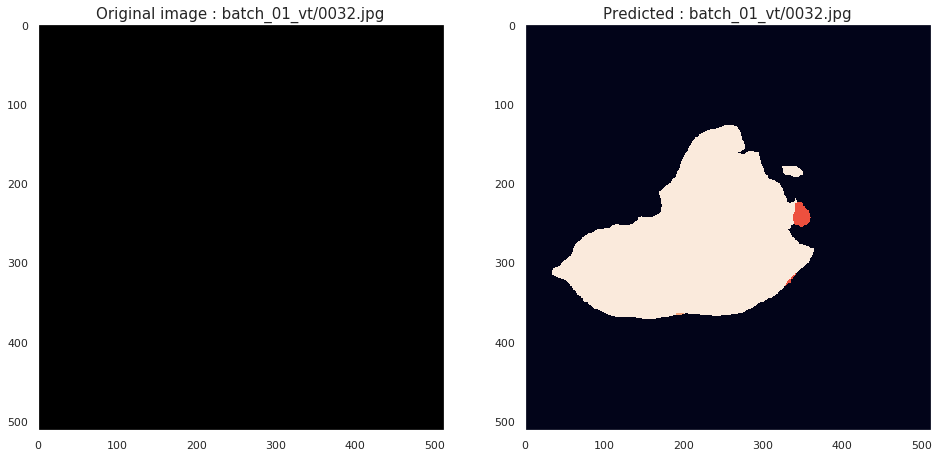

In [17]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [18]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(temp_images), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [44]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(f"./submission/{CFG.version}.csv", index=False)

Start prediction.
End prediction.


## hyper-param 저장